In [1]:
from ephysvibe.structures.bhv_data import BhvData
from ephysvibe.structures.lfp_data import LfpData
from ephysvibe.analysis import signal,layers
import numpy as np
from ephysvibe.task import task_constants,def_task
import matplotlib.pyplot as plt
import seaborn as sns
import gc
from ephysvibe.spike_sorting import config

In [2]:
path = '/envau/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/session_struct/session_struct/Riesling/lip/250_3/2023-03-01_10-18-38_Riesling_lip_e1_r1_lfp.h5'
bhv_path = '/envau/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/session_struct/Riesling/2023-03-01_10-18-38_Riesling_e1_r1_bhv.h5'
data_lfp_norm = LfpData.from_python_hdf5(path)
data_bhv = BhvData.from_python_hdf5(bhv_path)

In [5]:
# path = '/envau/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/session_struct/session_struct/Riesling/lip/250_3/2023-02-08_10-39-41_Riesling_lip_e1_r1_lfp.h5'
# data_lfp_filt = LfpData.from_python_hdf5(path)

In [3]:
data_lfp = data_lfp_norm

In [4]:
inside_rf = np.logical_or(np.logical_or(np.logical_or(data_bhv.sacc_code==125, data_bhv.sacc_code==126),data_bhv.sacc_code==127),data_bhv.sacc_code==120)
trial_idx = np.where(np.logical_and(np.logical_and(data_bhv.trial_error == 0, data_bhv.block == 2),inside_rf))[0]
trial_idx.shape
# task = def_task.create_task_frame(
#     condition=data_bhv.condition[trial_idx],
#     test_stimuli=data_bhv.test_stimuli[trial_idx],
#     samples_cond=task_constants.SAMPLES_COND,
#     neuron_cond=np.ones(1),
# )
# trial_in_idx=task[task['in_out']=='in']['trial_idx'].values

(50,)

In [24]:
trials_s_on = data_bhv.code_samples[
    trial_idx,
    np.where(data_bhv.code_numbers[trial_idx] == task_constants.EVENTS_B2["target_on"])[#
        1
    ],
]
t_before=20
# shifts = -(trials_s_on - t_before).astype(int)
# shifts = shifts[:,np.newaxis]

In [25]:
idx_start =data_lfp.idx_start[trial_idx]-t_before
idx_start = (data_bhv.code_samples[trial_idx][data_bhv.code_numbers[trial_idx]==task_constants.EVENTS_B2['target_on']]+idx_start).astype(int)
idx_end = (data_bhv.code_samples[trial_idx][data_bhv.code_numbers[trial_idx]==config.END_CODE]+idx_start).astype(int)

In [26]:
n_trials = len(idx_end)
n_ch = 32
max_len = int(max(idx_end-idx_start))
lfp_trials = np.full((n_trials,n_ch,max_len),np.nan)
for i_tr in range(n_trials):
    dur = int(idx_end[i_tr]-idx_start[i_tr])
    lfp_trials[i_tr,:,:dur] = data_lfp.lfp_values[:,idx_start[i_tr]:idx_end[i_tr]]

In [27]:
#LfpData.indep_roll(lfp_trials, shifts, axis=2)
# shift_sp = TrialsData.indep_roll(data.sp_samples[trial_idx[trial_in_idx]], shifts, axis=2)

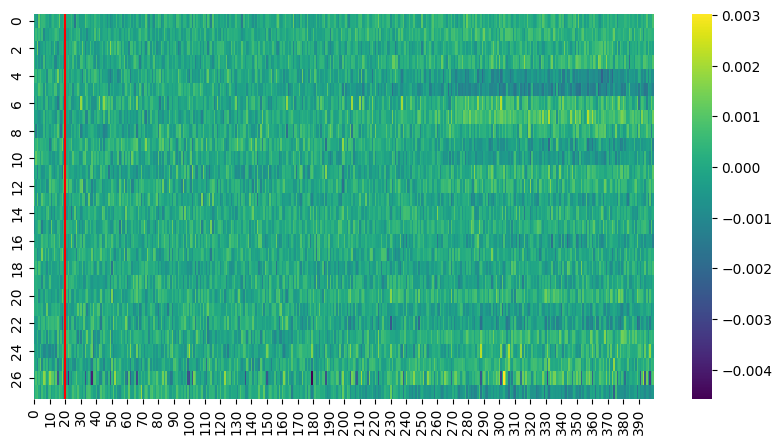

In [28]:
inter_channel_distance=50
step=2
csd=layers.compute_csd(lfp_trials.mean(axis=0)[:,:1500], inter_channel_distance, step=step)

# max_depth = inter_channel_distance*(n_ch-data.clusters_ch[0])+data.clusterdepth[0]
# ch_depth = np.concatenate([np.arange(inter_channel_distance,data.clusterdepth[0],inter_channel_distance),np.arange(data.clusterdepth[0], max_depth,inter_channel_distance)])

fig, ax = plt.subplots(figsize=(10,5)) 

sns.heatmap(csd[:,:400],cmap='viridis',ax=ax)
ax.vlines([t_before],0,n_ch-step * 2,colors='r', label="target_on")
# fig.legend(fontsize=9,loc='upper center')
# ax.set_title('CSD')
# ax.set(xlabel="Time (ms)", ylabel="Channels")
# a=ax.set_yticks(np.arange(0.5,n_ch-2*step+0.5))
#a=ax.set_yticklabels(ch_depth[step:-step].astype(int), rotation=0)
#ax.set_ylabel(ch_depth[step:-step].astype(int))

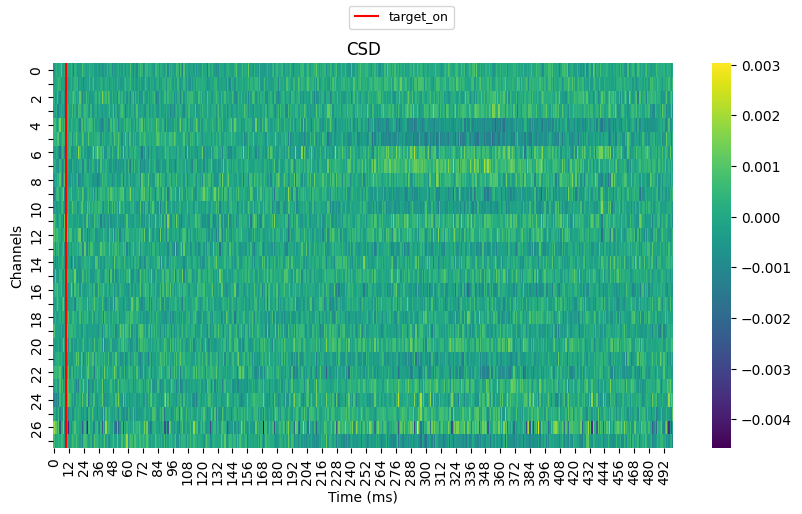

In [16]:
avg_lfp = lfp_trials[:,:,:1500].mean(axis=(2))
avg_lfp_trials = lfp_trials[:,:,:1500]-avg_lfp[:,:,np.newaxis]
csd_avg = layers.compute_csd(avg_lfp_trials.mean(axis=0)[:,:1500], inter_channel_distance, step=step)


# max_depth= inter_channel_distance*(n_ch-data.clusters_ch[0])+data.clusterdepth[0]
# ch_depth = np.concatenate([np.arange(inter_channel_distance,data.clusterdepth[0],inter_channel_distance),np.arange(data.clusterdepth[0], max_depth,inter_channel_distance)])

fig, ax = plt.subplots(figsize=(10,5)) 
start_plot =  0#t_before-50
sns.heatmap(csd_avg[:,start_plot:start_plot+500],cmap='viridis',ax=ax)
ax.vlines([t_before-start_plot],0,n_ch-step * 2,colors='r', label="target_on")
fig.legend(fontsize=9,loc='upper center')
ax.set_title('CSD')
ax.set(xlabel="Time (ms)", ylabel="Channels")
a=ax.set_yticks(np.arange(0.5,n_ch-2*step+0.5))

In [154]:
del a
plt.close(fig)
gc.collect()

44065

In [155]:
lfp_trials.shape

(80, 32, 3402)

In [156]:
avg_lfp_trials.shape

(80, 32, 1500)

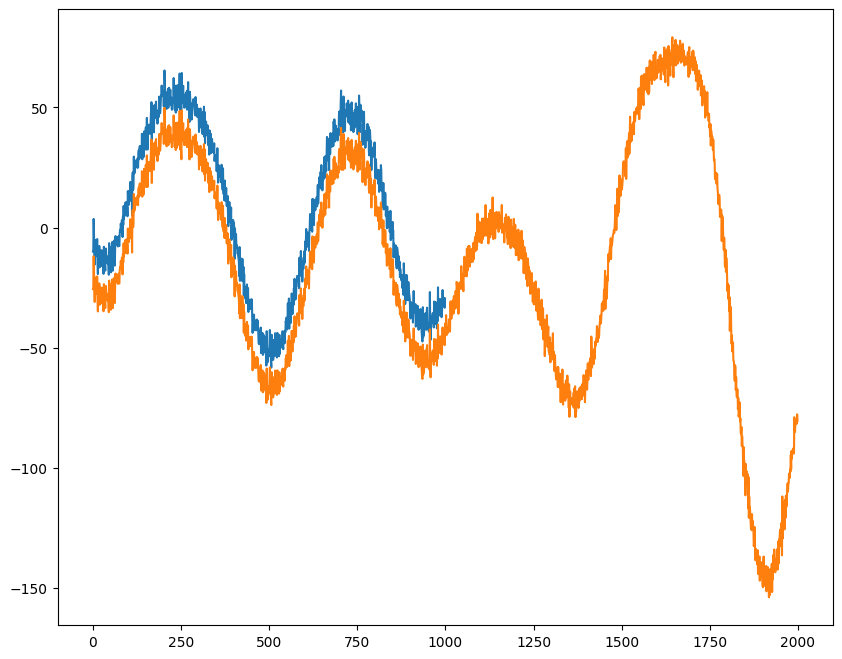

In [166]:
fig,ax = plt.subplots(figsize=(10,8))
a=ax.plot(avg_lfp_trials.mean(axis=0)[0,:1000].T)#+np.arange(0,32*100,100))
a=ax.plot(lfp_trials.mean(axis=0)[0,:2000].T)#+np.arange(0,32*100,100),'--')

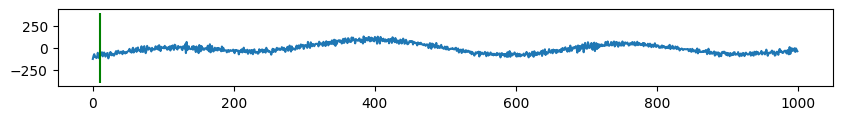

In [158]:
median_ch = np.median(lfp_trials,axis=1)
lfp_median_correction = lfp_trials-median_ch[:,np.newaxis,:]
fig,ax = plt.subplots(figsize=(10,1))
a=ax.plot(median_ch[0,:1000])
ax.vlines([t_before],-400,400,colors=['g'])

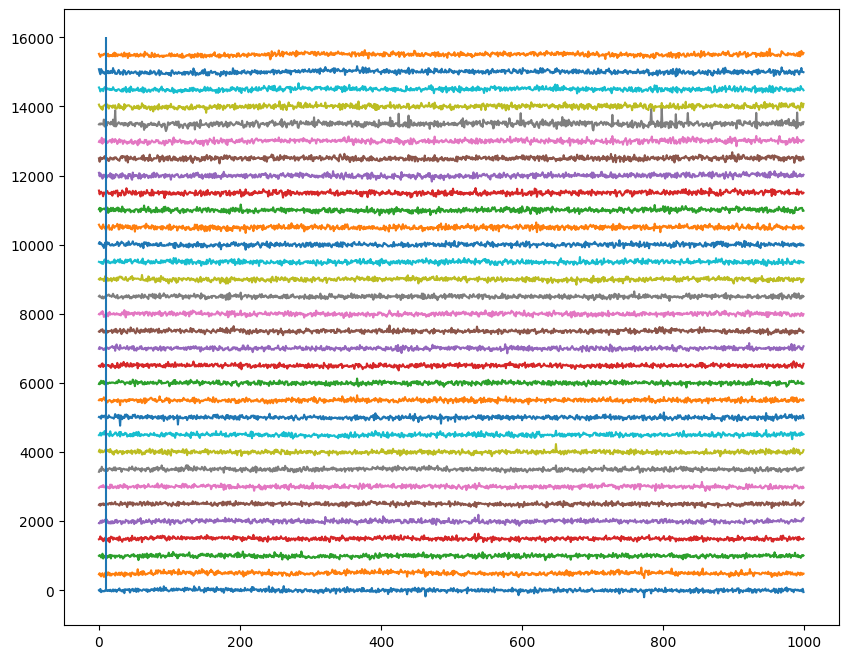

In [159]:
fig,ax = plt.subplots(figsize=(10,8))
a=ax.plot(lfp_median_correction[0,:,:1000].T+np.arange(0,32*500,500))
ax.vlines([t_before],0,32*500)

In [160]:
from mne import time_frequency
from scipy.fft import fft,fftfreq

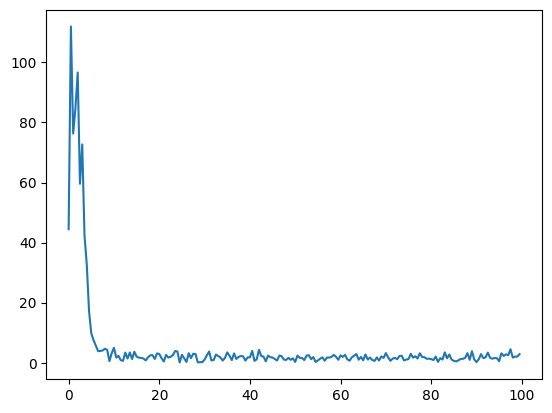

In [161]:
x=lfp_trials[5,29,:2000]
N=x.shape[0]
T = 1/1000
x0=fft(x,N,axis=0)
xf = fftfreq(N, T)[:N//10]
plt.plot(xf, 2.0/N * np.abs(x0[0:N//10]))

Effective window size : 0.256 (s)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s finished


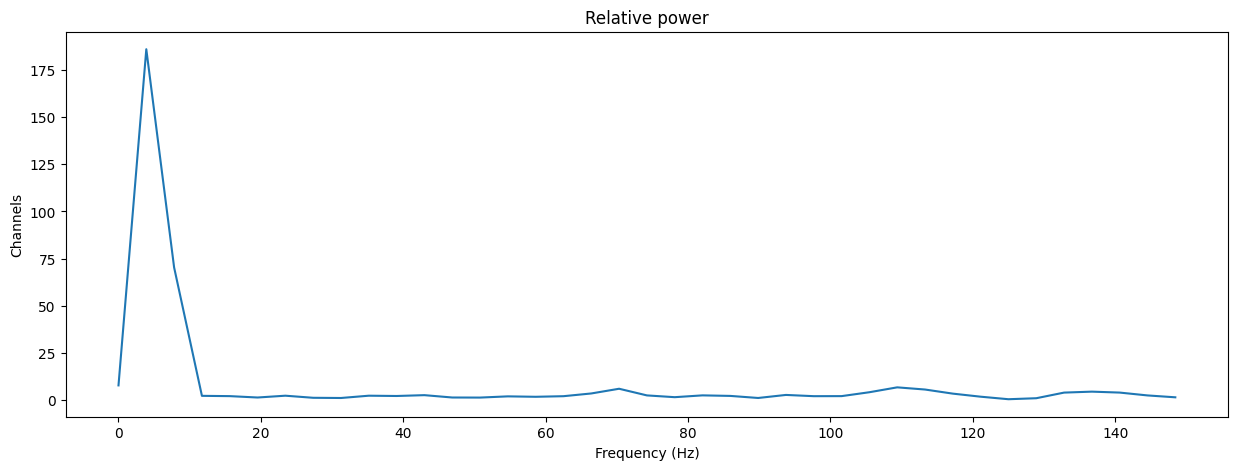

In [162]:
x=lfp_trials[:,:,:1000]
fmax=150
s_freq = 1000
w_size = 200
psd, freqs = time_frequency.psd_array_welch(
            x, fmax=fmax, sfreq=s_freq, n_per_seg=w_size
        )
# Plot RP
_,ax = plt.subplots(figsize=(15,5))
a=ax.plot(freqs,psd[0,30].T)
ax.set_title("Relative power")
ax.set(xlabel="Frequency (Hz)", ylabel="Channels")
# ax.set_yticks(np.flip(np.arange(0.5, n_channels  + 0.5)))
# ax.set_yticklabels(ch_depth.astype(int), rotation=0)

plt.show()

    Using multitaper spectrum estimation with 7 DPSS windows


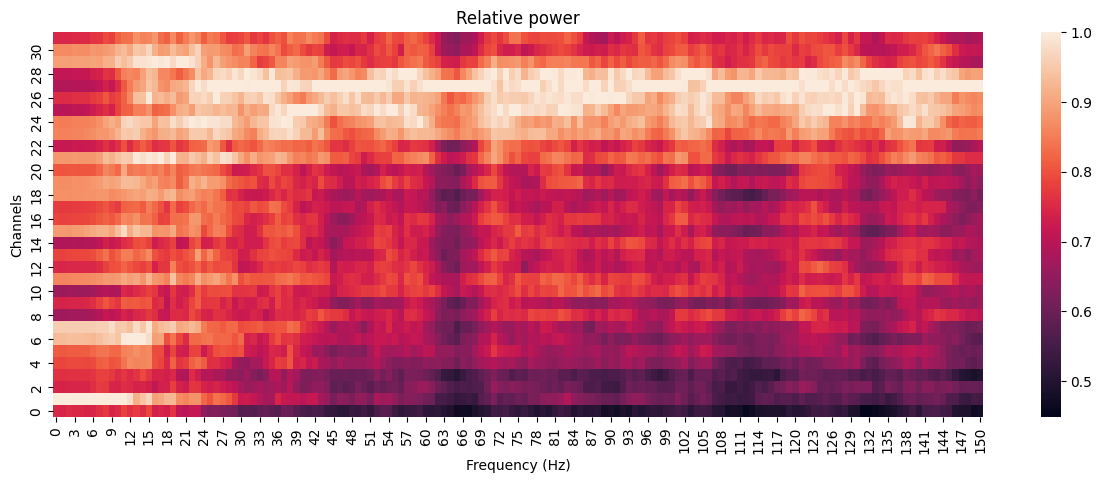

In [163]:
fmax=150
s_freq = 1000
w_size = 200
x=lfp_trials[:,:,:1000]
avg_psd,freqs = signal.compute_relative_power(x,psd_method='multitaper',fmax=150,s_freq = s_freq,w_size = w_size)
# Plot RP
_,ax = plt.subplots(figsize=(15,5))
sns.heatmap(avg_psd)
ax.set_title("Relative power")
ax.set(xlabel="Frequency (Hz)", ylabel="Channels")
# ax.set_yticks(np.flip(np.arange(0.5, n_channels  + 0.5)))
# ax.set_yticklabels(ch_depth.astype(int), rotation=0)
ax.invert_yaxis()
plt.show()

    Using multitaper spectrum estimation with 7 DPSS windows


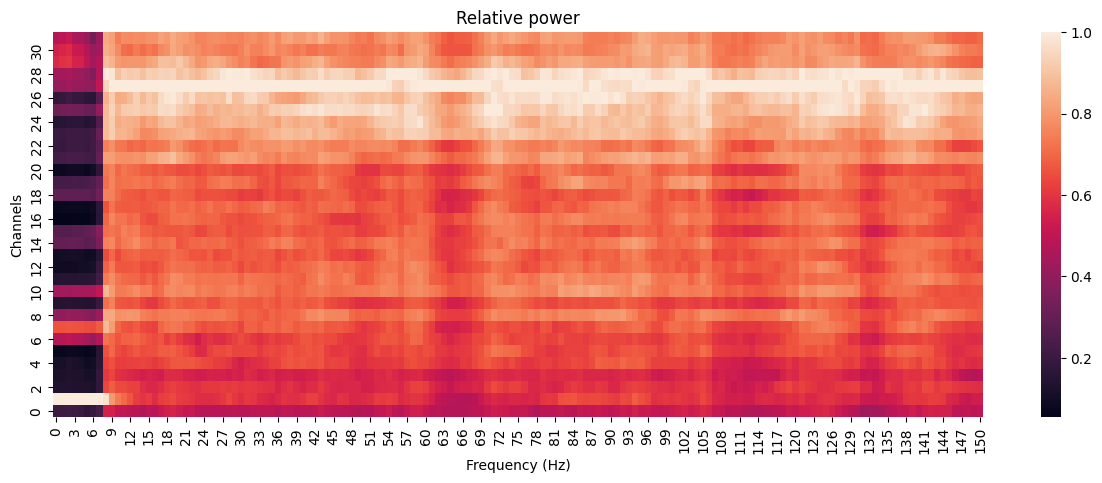

In [164]:
x=lfp_median_correction[:,:,:1000]#

avg_psd_median,freqs_median = signal.compute_relative_power(x,psd_method='multitaper',fmax=150,s_freq = s_freq,w_size = w_size)

# # Plot RP
# _,ax = plt.subplots(figsize=(15,5))
# sns.heatmap(avg_psd_median)
# ax.invert_yaxis()
# plt.show()

_,ax = plt.subplots(figsize=(15,5))
sns.heatmap(avg_psd_median)
ax.set_title("Relative power")
ax.set(xlabel="Frequency (Hz)", ylabel="Channels")
# ax.set_yticks(np.flip(np.arange(0.5, n_channels  + 0.5)))
# ax.set_yticklabels(ch_depth.astype(int), rotation=0)
ax.invert_yaxis()
plt.show()

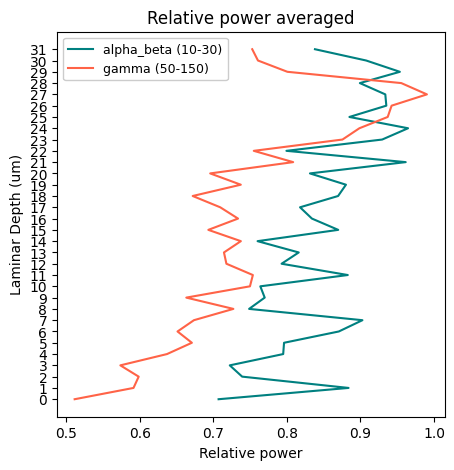

In [165]:
# compute relative power maps
rp_alpha_beta = avg_psd[:, np.where(np.logical_and(freqs > 10, freqs < 30))[0]]
rp_gamma = avg_psd[:, np.where(np.logical_and(freqs > 50, freqs < 150))[0]]
# Plot
fig,ax = plt.subplots(figsize=(5,5))
a=ax.plot(rp_alpha_beta.mean(axis=1),np.arange(0,32),label='alpha_beta (10-30)',color='teal')
a=ax.plot(rp_gamma.mean(axis=1),np.arange(0,32),label='gamma (50-150)',color='tomato')
a=ax.set_yticks(np.arange(0,32))
ax.legend(fontsize=9,columnspacing=0.5,facecolor='white', framealpha=1,loc='upper left')
ax.set_title("Relative power averaged")
ax.set(xlabel="Relative power", ylabel="Laminar Depth (um)")
ax.set_yticks(np.flip(np.arange(0, 32)))
a=1#ax.set_yticklabels(ch_depth.astype(int), rotation=0)